In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pytz
import calendar
import datetime as dt
import logging
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

C:\Users\bluey\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bluey\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\bluey\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
logger = logging.getLogger('trade_decomp')

# <font color="grey"> $\quad$ Trade decomposition - sample notebook </font>

$\newcommand{\vct}[1]{\mathbf{#1}}$
$\newcommand{\mtx}[1]{\mathbf{#1}}$
$\newcommand{\e}{\varepsilon}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\minimize}{\mathrm{minimize}\quad}$
$\newcommand{\maximize}{\mathrm{maximize}\quad}$
$\newcommand{\subjto}{\quad\text{subject to}\quad}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\C}{\mathbb{C}}$
$\newcommand{\N}{\mathbb{N}}$
$\newcommand{\Z}{\mathbb{Z}}$
$\newcommand{Prob}{\mathbb{P}}$
$\newcommand{Expect}{\mathbb{E}}$
$\newcommand{Cov}{\mathrm{Cov}}$
$\newcommand{Var}{\mathrm{Var}}$
$\newcommand{\trans}{T}$
$\newcommand{\ip}[2]{\langle {#1}, {#2} \rangle}$
$\newcommand{\zerovct}{\vct{0}}$
$\newcommand{\diff}[1]{\mathrm{d}{#1}}$
$\newcommand{\conv}{\operatorname{conv}}$
$\newcommand{\inter}{{\operatorname{int}}}$

### <font color="grey">  Table of Contents</font>

1. #### <a href='#chapter1'>Data</a>
2. #### <a href='#chapter2'>Trade decomposition</a>

###  <a id='chapter1'> <font color="grey">1. Data </font></a>

Data is currently available for 5 products, namely perpetual futures contracts for the following pairs: BTC-USDT, ETH-USDT, SOL-USDT, DOGE-USDT and LINK-USDT. The details on these products are not important for the time being, they just represent time series. Data is available for trades and quotes (level 1 limit order book) for a period from June to end of August. For each month, the data begins at 00:01 of the first day and ends at 23:50. The data for each month is contained in parquet files of the form 'BTCUSDT_07_trade.parquet' or 'ETHUSDT_08_book.parquet'.

The timestamps are given in nanosecond resolution as Unix timestamps, but the granularity of the data is not that fine. A simple dataloader and some helper function to convert Python datetime objects or strings of the form '240802.1450' into timestamps are provided. The 'book' data contains best bid and ask prices with corresponding volumes. The 'trade' data contains trades, with a signed quantity representing direction. There is also an associated trade id in order to identify individual trades.

The book data is mainly to determine the price movements and for potential backtests. In the original dataset there are more timestamps (depending on when the data was sent or received) but I don't think this matters at the moment. One could try to align what happens in the trades with what happens in the book dataset.

We make heavy use of [polars](https://pola.rs/), for the simple reason of performance. If one is not used to it, the learning curve can be steep but it will make things quicker in the long run.

In [5]:
RCS = [f"{coin}USDT" for coin in ["BTC", "ETH", "SOL", "DOGE", "LINK"]]
TYPE = ['book', 'trade']
MONTHS = ['06', '07', '08']
TIMES = ['240701.0001', '240731.2350']
PATH = 'trnk/'    # Change if needed

In [6]:
from typing import Union
import datetime as dt
import pytz
import calendar

def nanoseconds(input: Union[str, dt.datetime]) -> int:
    """Convert datetime or string input to return nanosecond UNIX timestamp (int).
    
    The input can by one of the following:
    - YYMMDD.HHMM
    - dt.datetime (with or without timezone)
    
    Example:
        >>> nanoseconds(dt.datetime(2018, 3, 20, 18, 30, tzinfo=pytz.timezone('America/Chicago')))
        1521588600000000000
    
        >>> (nanoseconds('230629.0501') - nanoseconds('230629.0500'))/1_000_000_000
        60.0
    
    :param input: dt.datetime or string
    :return: timestamp in nanoseconds
    """
    assert isinstance(input, dt.datetime) or isinstance(input, str)
    if isinstance(input, str):
        try:
            input = dt.datetime.strptime(input, "%y%m%d.%H%M")
        except ValueError:
            print("Input string not in correct format")
    # Deal with some timezone issues
    used_tz = input.tzinfo if input.tzinfo is not None else pytz.utc
    input = used_tz.localize(input.replace(tzinfo=None))
    time_tuple = input.utctimetuple()
    timestamp = 1000 * (calendar.timegm(time_tuple) * 1000 * 1000 + input.microsecond)
    return timestamp


In [7]:
def load_data(product: str, 
              times: list[str], 
              type: str = 'trade', 
              path: str = PATH) -> pl.DataFrame:
    """Load data for a given product.

    :param product: string (for example, 'BTCUSDT')
    :param times: tuble of strings (for example, ['240701.0001', '240731.2350']
    :param type: string, one of 'trade' or 'book'
    :param path: string, path where data is found
    :return: timestamp in nanoseconds
    """
    
    dtimes = [dt.datetime.strptime(t, "%y%m%d.%H%M") for t in times]
    if dtimes[0].month != dtimes[1].month:
        print("Start and end date need to be from same month.")
        return

    assert type in ['trade', 'book']
    filename = "{}{}_0{}_{}.parquet".format(path, product, dtimes[0].month, type)
    logger.info("Loading data from %s"%filename)
    try:
        df = pl.read_parquet(filename)
    except OSError as err:
        print("Could not open file %s" % filename)

    return df.filter(pl.col('ts').is_between(nanoseconds(times[0]), nanoseconds(times[1])))

## Test exploration of the data

In [27]:
df = load_data('BTCUSDT', ['240707.0800', '240707.2000'], 'book')

In [28]:
df

ts,prc__s0,prc__s1,vol__s0,vol__s1
u64,f64,f64,f64,f64
1720339200000500000,57344.4,57344.5,6.676,4.664
1720339200053500000,57344.4,57344.5,6.796,4.664
1720339200082500000,57344.4,57344.5,6.796,4.316
1720339200085500000,57344.4,57344.5,6.796,2.353
1720339200086500000,57344.4,57344.5,6.796,2.351
…,…,…,…,…
1720382399741500000,57133.8,57133.9,23.08,12.433
1720382399743500000,57133.8,57133.9,23.02,12.433
1720382399744500000,57133.8,57133.9,23.095,12.433


In [10]:
# Add a human readable timestamp column and midprices
df = df.with_columns([pl.from_epoch('ts', time_unit='ns').alias('dts'),
                      ((pl.col('prc__s0')+pl.col('prc__s1'))/2).alias('mid')])
df.head()

ts,prc__s0,prc__s1,vol__s0,vol__s1,dts,mid
u64,f64,f64,f64,f64,datetime[ns],f64
1720339200000500000,57344.4,57344.5,6.676,4.664,2024-07-07 08:00:00.000500,57344.45
1720339200053500000,57344.4,57344.5,6.796,4.664,2024-07-07 08:00:00.053500,57344.45
1720339200082500000,57344.4,57344.5,6.796,4.316,2024-07-07 08:00:00.082500,57344.45
1720339200085500000,57344.4,57344.5,6.796,2.353,2024-07-07 08:00:00.085500,57344.45
1720339200086500000,57344.4,57344.5,6.796,2.351,2024-07-07 08:00:00.086500,57344.45


In [26]:
df.tail()

ts,prc__s0,prc__s1,vol__s0,vol__s1,dts,mid
u64,f64,f64,f64,f64,datetime[ns],f64
1720382399741500000,57133.8,57133.9,23.08,12.433,2024-07-07 19:59:59.741500,57133.85
1720382399743500000,57133.8,57133.9,23.02,12.433,2024-07-07 19:59:59.743500,57133.85
1720382399744500000,57133.8,57133.9,23.095,12.433,2024-07-07 19:59:59.744500,57133.85
1720382399745500000,57133.8,57133.9,23.215,12.433,2024-07-07 19:59:59.745500,57133.85
1720382399793500000,57133.8,57133.9,23.215,12.553,2024-07-07 19:59:59.793500,57133.85


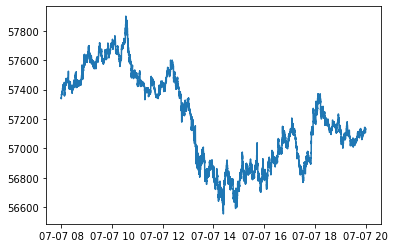

In [12]:
import matplotlib.pyplot as plt

# Convert Polars columns to numpy arrays or pandas Series
x = df['dts'].to_numpy()  # Convert 'dts' column to numpy array
y = df['mid'].to_numpy()  # Convert 'mid' column to numpy array

# Plot the data
plt.plot(x, y)
plt.show()


Take a shorter period (10 minues) and plot the bid-ask spread

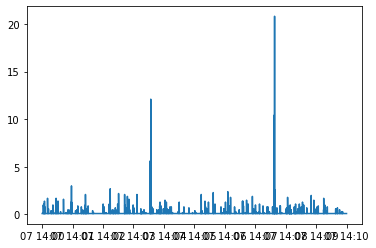

In [16]:
# Filter the DataFrame
sdf = df.filter(pl.col('ts').is_between(nanoseconds('240707.1400'), nanoseconds('240707.1410')))

# Extract the columns as lists for plotting
x = sdf.get_column("dts").to_list()  # Extract 'dts' as a list
y = (sdf.get_column("prc__s1") - sdf.get_column("prc__s0")).to_list()  # Calculate difference and convert to list

# Plot the data
plt.plot(x, y)
plt.show()

Now look at some trade data

In [17]:
tdf = load_data('BTCUSDT', ['240707.0800', '240707.2000'], 'trade')

In [18]:
print(tdf.shape)
tdf.head()

(1170641, 4)


ts,trade_id,prc,qty
u64,u64,f64,f64
1720339200092500000,5143482861,57344.5,0.002
1720339200092500000,5143482862,57344.5,0.047
1720339200092500000,5143482863,57344.5,0.002
1720339200092500000,5143482864,57344.5,0.1
1720339200092500000,5143482865,57344.5,0.1


The quantities can be positive or negative, corresponding to buy or sell orders. Looking at the data, there are several trades happening at the exact same time. It makes sense to aggregate these.

In [19]:
tdf = tdf.group_by(['ts','prc'], maintain_order=True).agg(pl.col('trade_id').first(), pl.col('qty').sum())
tdf.head()

ts,prc,trade_id,qty
u64,f64,u64,f64
1720339200092500000,57344.5,5143482861,1.976
1720339200094500000,57346.0,5143482880,0.002
1720339200094500000,57347.0,5143482881,0.011
1720339200096500000,57347.1,5143482887,0.01
1720339200108500000,57347.1,5143482888,0.021


In [20]:
# Add human readable timestamps
tdf = tdf.with_columns([pl.from_epoch('ts', time_unit='ns').alias('dts')])

In [24]:
tdf.head()

ts,prc,trade_id,qty,dts
u64,f64,u64,f64,datetime[ns]
1720339200092500000,57344.5,5143482861,1.976,2024-07-07 08:00:00.092500
1720339200094500000,57346.0,5143482880,0.002,2024-07-07 08:00:00.094500
1720339200094500000,57347.0,5143482881,0.011,2024-07-07 08:00:00.094500
1720339200096500000,57347.1,5143482887,0.01,2024-07-07 08:00:00.096500
1720339200108500000,57347.1,5143482888,0.021,2024-07-07 08:00:00.108500


In [25]:
tdf.tail()

ts,prc,trade_id,qty,dts
u64,f64,u64,f64,datetime[ns]
1720382398748500000,57132.1,5144653493,0.012,2024-07-07 19:59:58.748500
1720382398749500000,57132.1,5144653501,0.009,2024-07-07 19:59:58.749500
1720382398957500000,57133.9,5144653506,0.002,2024-07-07 19:59:58.957500
1720382399521500000,57133.9,5144653507,0.003,2024-07-07 19:59:59.521500
1720382399618500000,57133.9,5144653508,0.023,2024-07-07 19:59:59.618500


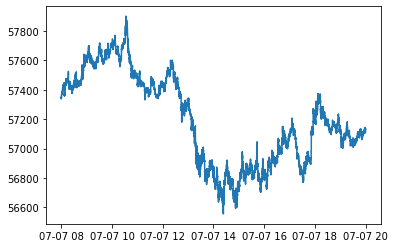

In [22]:
import polars as pl
import matplotlib.pyplot as plt

# Assuming `tdf` is a Polars DataFrame

# Extract the columns as lists
x = tdf.get_column("dts").to_list()  # Extract the 'dts' column
y = tdf.get_column("prc").to_list()  # Extract the 'prc' column

# Plot the data
plt.plot(x, y)
plt.show()


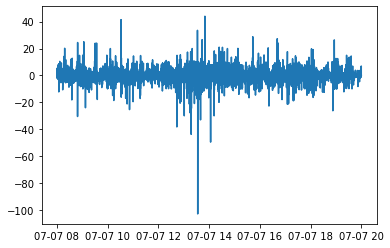

In [23]:
import polars as pl
import matplotlib.pyplot as plt

# Assuming `tdf` is a Polars DataFrame

# Extract columns using Polars-native methods
x = tdf.get_column("dts").to_numpy()  # Convert 'dts' column to NumPy array
y = tdf.get_column("qty").to_numpy()  # Convert 'qty' column to NumPy array

# Plot the data
plt.plot(x, y)
plt.show()


#  <a id='chapter2'> <font color="grey">2. Trade decomposition </font></a> 
## My Additions

Here is where one should be creative. One can use polars functionality such as various ways of doing joins to align the trade data for different products and then classify the trades into one of the criteria. Ideally, this should be done using the rolling window functionality of polars and without for loops.

## Load the trade data for 5 assets

In [8]:
BTC_tdf = load_data('BTCUSDT', ['240707.0800', '240708.2000'], 'trade')
ETH_tdf = load_data('ETHUSDT', ['240707.0800', '240708.2000'], 'trade')
SOL_tdf = load_data('SOLUSDT', ['240707.0800', '240708.2000'], 'trade')
DOGE_tdf = load_data('DOGEUSDT', ['240707.0800', '240708.2000'], 'trade')
LINK_tdf = load_data('LINKUSDT', ['240707.0800', '240708.2000'], 'trade')

## Process trades with timestamps

In [9]:
# Agg trades at same time
BTC_tdf = BTC_tdf.group_by(['ts','prc'], maintain_order=True).agg(pl.col('trade_id').first(), pl.col('qty').sum())
ETH_tdf = ETH_tdf.group_by(['ts','prc'], maintain_order=True).agg(pl.col('trade_id').first(), pl.col('qty').sum())
SOL_tdf = SOL_tdf.group_by(['ts','prc'], maintain_order=True).agg(pl.col('trade_id').first(), pl.col('qty').sum())
DOGE_tdf = DOGE_tdf.group_by(['ts','prc'], maintain_order=True).agg(pl.col('trade_id').first(), pl.col('qty').sum())
LINK_tdf = LINK_tdf.group_by(['ts','prc'], maintain_order=True).agg(pl.col('trade_id').first(), pl.col('qty').sum())

In [10]:
# Add human readable timestamps
BTC_tdf = BTC_tdf.with_columns([pl.from_epoch('ts', time_unit='ns').alias('dts')])
ETH_tdf = ETH_tdf.with_columns([pl.from_epoch('ts', time_unit='ns').alias('dts')])
SOL_tdf = SOL_tdf.with_columns([pl.from_epoch('ts', time_unit='ns').alias('dts')])
DOGE_tdf = DOGE_tdf.with_columns([pl.from_epoch('ts', time_unit='ns').alias('dts')])
LINK_tdf = LINK_tdf.with_columns([pl.from_epoch('ts', time_unit='ns').alias('dts')])

## Add label for if Buy or Sell and rearrange cols

In [11]:
# Dictionary of DataFrames
tdf_namedic = {
    "BTC_tdf": BTC_tdf,
    "ETH_tdf": ETH_tdf,
    "SOL_tdf": SOL_tdf,
    "DOGE_tdf": DOGE_tdf,
    "LINK_tdf": LINK_tdf,
}

# Process each DataFrame
for name in tdf_namedic.keys():
    print(f"Processing {name}")
    tdf_namedic[name] = (
        tdf_namedic[name]
        .with_columns(
            pl.when(pl.col("qty") >= 0)
            .then(pl.lit("Buy"))
            .otherwise(pl.lit("Sell"))
            .alias("Side")
        )
        .select(["dts", "prc", "qty", "Side", "trade_id","ts"])  # Rearrange columns
    )


Processing BTC_tdf
Processing ETH_tdf
Processing SOL_tdf
Processing DOGE_tdf
Processing LINK_tdf


In [12]:
BTC_tdf = tdf_namedic['BTC_tdf']
ETH_tdf = tdf_namedic['ETH_tdf']
SOL_tdf = tdf_namedic['SOL_tdf']
DOGE_tdf = tdf_namedic['DOGE_tdf']
LINK_tdf = tdf_namedic['LINK_tdf']

In [13]:
BTC_tdf

dts,prc,qty,Side,trade_id,ts
datetime[ns],f64,f64,str,u64,u64
2024-07-07 08:00:00.092500,57344.5,1.976,"""Buy""",5143482861,1720339200092500000
2024-07-07 08:00:00.094500,57346.0,0.002,"""Buy""",5143482880,1720339200094500000
2024-07-07 08:00:00.094500,57347.0,0.011,"""Buy""",5143482881,1720339200094500000
2024-07-07 08:00:00.096500,57347.1,0.01,"""Buy""",5143482887,1720339200096500000
2024-07-07 08:00:00.108500,57347.1,0.021,"""Buy""",5143482888,1720339200108500000
…,…,…,…,…,…
2024-07-08 19:59:59.605500,56461.8,0.002,"""Buy""",5149953339,1720468799605500000
2024-07-08 19:59:59.605500,56462.0,0.002,"""Buy""",5149953340,1720468799605500000
2024-07-08 19:59:59.613500,56462.3,0.006,"""Buy""",5149953341,1720468799613500000


## Combine trades together to be one dataframe of trades

In [14]:
BTC_labeled = BTC_tdf.with_columns(pl.lit("BTC").alias("product"))
ETH_labeled = ETH_tdf.with_columns(pl.lit("ETH").alias("product"))
SOL_labeled = SOL_tdf.with_columns(pl.lit("SOL").alias("product"))
DOGE_labeled = DOGE_tdf.with_columns(pl.lit("DOGE").alias("product"))
LINK_labeled = LINK_tdf.with_columns(pl.lit("LINK").alias("product"))

all_trades = pl.concat([BTC_labeled, ETH_labeled, SOL_labeled, DOGE_labeled, LINK_labeled])


In [15]:
all_trades

dts,prc,qty,Side,trade_id,ts,product
datetime[ns],f64,f64,str,u64,u64,str
2024-07-07 08:00:00.092500,57344.5,1.976,"""Buy""",5143482861,1720339200092500000,"""BTC"""
2024-07-07 08:00:00.094500,57346.0,0.002,"""Buy""",5143482880,1720339200094500000,"""BTC"""
2024-07-07 08:00:00.094500,57347.0,0.011,"""Buy""",5143482881,1720339200094500000,"""BTC"""
2024-07-07 08:00:00.096500,57347.1,0.01,"""Buy""",5143482887,1720339200096500000,"""BTC"""
2024-07-07 08:00:00.108500,57347.1,0.021,"""Buy""",5143482888,1720339200108500000,"""BTC"""
…,…,…,…,…,…,…
2024-07-08 19:59:56.574500,12.909,-0.26,"""Sell""",1012842207,1720468796574500000,"""LINK"""
2024-07-08 19:59:56.876500,12.909,-0.08,"""Sell""",1012842208,1720468796876500000,"""LINK"""
2024-07-08 19:59:56.995500,12.909,-7.74,"""Sell""",1012842209,1720468796995500000,"""LINK"""


## Add a metric to decide which 5 min bucket trades are in

In [16]:
all_trades = (
    all_trades
    .with_columns(
        pl.col("dts").dt.truncate("5m").alias("bucket_5m")
    )
)

In [17]:
all_trades

dts,prc,qty,Side,trade_id,ts,product,bucket_5m
datetime[ns],f64,f64,str,u64,u64,str,datetime[ns]
2024-07-07 08:00:00.092500,57344.5,1.976,"""Buy""",5143482861,1720339200092500000,"""BTC""",2024-07-07 08:00:00
2024-07-07 08:00:00.094500,57346.0,0.002,"""Buy""",5143482880,1720339200094500000,"""BTC""",2024-07-07 08:00:00
2024-07-07 08:00:00.094500,57347.0,0.011,"""Buy""",5143482881,1720339200094500000,"""BTC""",2024-07-07 08:00:00
2024-07-07 08:00:00.096500,57347.1,0.01,"""Buy""",5143482887,1720339200096500000,"""BTC""",2024-07-07 08:00:00
2024-07-07 08:00:00.108500,57347.1,0.021,"""Buy""",5143482888,1720339200108500000,"""BTC""",2024-07-07 08:00:00
…,…,…,…,…,…,…,…
2024-07-08 19:59:56.574500,12.909,-0.26,"""Sell""",1012842207,1720468796574500000,"""LINK""",2024-07-08 19:55:00
2024-07-08 19:59:56.876500,12.909,-0.08,"""Sell""",1012842208,1720468796876500000,"""LINK""",2024-07-08 19:55:00
2024-07-08 19:59:56.995500,12.909,-7.74,"""Sell""",1012842209,1720468796995500000,"""LINK""",2024-07-08 19:55:00


## Do trades per 5 min interval per product, for all trades and do the difference between these

In [18]:
# Count trades per (product, 5-minute bucket)
df_counts = (
    all_trades
    .group_by(["product", "bucket_5m"])
    .agg([
        pl.count().alias("N_i")  # Number of trades in that 5-min for each product
    ])
)

# Compute total trades per 5-minute interval (all products)
df_total = (
    all_trades
    .group_by("bucket_5m")
    .agg([
        pl.count().alias("N_total")  # Total trades in this 5-min bucket
    ])
)

# Join to compute N_{-i} = N_total - N_i
df_counts = df_counts.join(df_total, on="bucket_5m", how="left").with_columns([
    (pl.col("N_total") - pl.col("N_i")).alias("N_minus_i")
])



C:\Users\bluey\AppData\Local\Temp/ipykernel_20256/801336529.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("N_i")  # Number of trades in that 5-min for each product
C:\Users\bluey\AppData\Local\Temp/ipykernel_20256/801336529.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("N_total")  # Total trades in this 5-min bucket


Do it in pandas on subset dataframe with less rows all_trades_pd

### Decided to work using pandas for ease of use and not much performance drop after testing (and maybe translate back afterwards)

## We work with all_trades_pd for now which is the first 20,000 of our all_trades polars df but now in pandas (since it is faster to write code and performance seemed similar, but also very slow)

In [20]:
all_trades_wholepd = all_trades.to_pandas()

In [21]:
all_trades_pd = all_trades.to_pandas().head(20000)


In [22]:
df_counts_wholepd = df_counts.to_pandas()

In [25]:
df_counts

product,bucket_5m,N_i,N_total,N_minus_i
str,datetime[ns],u32,u32,u32
"""DOGE""",2024-07-07 11:35:00,463,6005,5542
"""DOGE""",2024-07-07 22:00:00,1500,21535,20035
"""ETH""",2024-07-08 06:40:00,6977,18321,11344
"""ETH""",2024-07-07 10:50:00,2135,7659,5524
"""LINK""",2024-07-07 12:00:00,635,10480,9845
…,…,…,…,…
"""ETH""",2024-07-08 00:30:00,6170,19373,13203
"""ETH""",2024-07-07 17:00:00,2709,9251,6542
"""LINK""",2024-07-07 21:45:00,368,11399,11031


In [24]:
all_trades_pd

,dts,prc,qty,Side,trade_id,ts,product,bucket_5m
0,2024-07-07 08:00:00.092500,57344.5,1.976,Buy,5143482861,1720339200092500000,BTC,2024-07-07 08:00:00
1,2024-07-07 08:00:00.094500,57346.0,0.002,Buy,5143482880,1720339200094500000,BTC,2024-07-07 08:00:00
2,2024-07-07 08:00:00.094500,57347.0,0.011,Buy,5143482881,1720339200094500000,BTC,2024-07-07 08:00:00
3,2024-07-07 08:00:00.096500,57347.1,0.010,Buy,5143482887,1720339200096500000,BTC,2024-07-07 08:00:00
4,2024-07-07 08:00:00.108500,57347.1,0.021,Buy,5143482888,1720339200108500000,BTC,2024-07-07 08:00:00
...,...,...,...,...,...,...,...,...
19995,2024-07-07 08:27:36.617500,57419.1,0.042,Buy,5143522607,1720340856617500000,BTC,2024-07-07 08:25:00
19996,2024-07-07 08:27:36.875500,57419.0,-0.010,Sell,5143522608,1720340856875500000,BTC,2024-07-07 08:25:00
19997,2024-07-07 08:27:36.931500,57419.1,0.018,Buy,5143522609,1720340856931500000,BTC,2024-07-07 08:25:00
19998,2024-07-07 08:27:36.962500,57419.0,-0.349,Sell,5143522610,1720340856962500000,BTC,2024-07-07 08:25:00


We now calculate df_counts but just for our 20,000 rows in all_trades pd and call this df_counts_pd

In [26]:
import pandas as pd

# Ensure 'bucket_5m' column is properly formatted for all_trades_pd
all_trades_pd["bucket_5m"] = all_trades_pd["dts"].dt.floor("5min")

# Step 1: Count trades per (product, 5-minute bucket) → N_i
df_counts_pd = (
    all_trades_pd
    .groupby(["product", "bucket_5m"])
    .size()
    .reset_index(name="N_i")  # Rename count column to "N_i"
)

# Step 2: Count total trades per 5-minute bucket → N_total
df_total_trades_pd = (
    all_trades_pd
    .groupby("bucket_5m")
    .size()
    .reset_index(name="N_total")  # Rename count column to "N_total"
)

# Step 3: Merge to compute N_minus_i
df_counts_pd = df_counts_pd.merge(df_total_trades_pd, on="bucket_5m", how="left")
df_counts_pd["N_minus_i"] = df_counts_pd["N_total"] - df_counts_pd["N_i"]

In [27]:
df_counts_pd

,product,bucket_5m,N_i,N_total,N_minus_i
0,BTC,2024-07-07 08:00:00,4637,4637,0
1,BTC,2024-07-07 08:05:00,3851,3851,0
2,BTC,2024-07-07 08:10:00,2801,2801,0
3,BTC,2024-07-07 08:15:00,4182,4182,0
4,BTC,2024-07-07 08:20:00,2653,2653,0
5,BTC,2024-07-07 08:25:00,1876,1876,0


In this example only BTC is traded within the time frame 

# Delta is neighbourhood either side (not half either side)
The code takes a delta window in ns and categorises trades based on this (doesn't separate buys and sells)

In [33]:
import pandas as pd
import numpy as np

def label_trades_for_delta(df_trades: pd.DataFrame, delta_ns: float) -> pd.DataFrame:
    """
    Labels trades as 'iso', 'nis-s', 'nis-c', or 'nis-b' for a given delta 
    (time window +/- delta_ns around each trade).
    
    Parameters:
        df_trades (pd.DataFrame): Trade data containing columns ['product', 'dts'].
        delta_ns (float): Time window for co-occurrence in nanoseconds.
        
    Returns:
        pd.DataFrame: Original trades with a new 'cooc_type' column.
    """
    # Ensure the 'dts' column is properly converted to datetime
    df_trades["dts"] = pd.to_datetime(df_trades["dts"], errors="coerce")
    
    # Convert timestamps to integer nanoseconds
    df_trades["dts_ns"] = df_trades["dts"].view(np.int64)

    # Sort by timestamp
    df_trades = df_trades.sort_values("dts_ns").reset_index(drop=True)

    # Extract time column as NumPy array (in nanoseconds)
    times = df_trades["dts_ns"].values

    # Initialize the co-occurrence type array
    cooc_types = np.empty(len(df_trades), dtype=object)

    # Iterate over trades and classify
    for i in range(len(df_trades)):
        t = times[i]
        prod = df_trades.at[i, "product"]

        left_bound = t - delta_ns
        right_bound = t + delta_ns

        # Perform binary search for the time window
        start_idx = np.searchsorted(times, left_bound, side="left")
        end_idx = np.searchsorted(times, right_bound, side="right")

        # Get neighboring trades, excluding the current row
        if start_idx <= i < end_idx:
            neighbors = df_trades.iloc[
                list(range(start_idx, i)) + list(range(i + 1, end_idx))
            ]
        else:
            neighbors = df_trades.iloc[start_idx:end_idx]

        unique_neighbor_prods = neighbors["product"].unique()

        # Determine co-occurrence type
        if len(unique_neighbor_prods) == 0:
            cooc_type = "iso"
        elif len(unique_neighbor_prods) == 1:
            cooc_type = "nis-s" if prod in unique_neighbor_prods else "nis-c"
        else:
            cooc_type = "nis-b"

        cooc_types[i] = cooc_type

    df_trades["cooc_type"] = cooc_types
    return df_trades


Tests Below for some synthetic data to make sure logic works

In [34]:
import pandas as pd

# Define a common timestamp as the base for all tests
base_time = pd.Timestamp("2024-07-07 12:00:00")

# Create test trades dataset
df_test_trades = pd.DataFrame({
    "product": ["BTC", "ETH", "ETH", "BTC", "ETH", "ETH", "ETH", "ETH"],
    "dts": [
        base_time,                      # Trade 0 (ISO) - Fully isolated
        base_time + pd.Timedelta("1ms"),  # Trade 1 (NIS-S) - Same product, within delta
        base_time + pd.Timedelta("2ms"), # Trade 2 (NIS-S) - Still within delta
        base_time + pd.Timedelta("7ms"), # Trade 3 (ISO) - Too far apart
        
        base_time,                      # Trade 4 (ISO) - Different product, isolated
        base_time + pd.Timedelta("12ms"),  # Trade 5 (NIS-C) - Different product, within delta
        base_time + pd.Timedelta("20ms"),  # Trade 6 (NIS-B) - Different product, near both
        base_time + pd.Timedelta("25ms") # Trade 7 (ISO) - Too far apart
    ]
})

# Define a small delta (5ms) for a sensitive test
delta_ns_test = 5_000_000  # 5ms = 5,000,000ns

# Apply function to label trades
df_labeled_test = label_trades_for_delta(df_test_trades.copy(), delta_ns_test)

# Print results
df_labeled_test[["product", "dts", "cooc_type"]]


,product,dts,cooc_type
0,BTC,2024-07-07 12:00:00.000,nis-c
1,ETH,2024-07-07 12:00:00.000,nis-b
2,ETH,2024-07-07 12:00:00.001,nis-b
3,ETH,2024-07-07 12:00:00.002,nis-b
4,BTC,2024-07-07 12:00:00.007,nis-c
5,ETH,2024-07-07 12:00:00.012,nis-c
6,ETH,2024-07-07 12:00:00.020,nis-s
7,ETH,2024-07-07 12:00:00.025,nis-s


Apply to calculate delta on our 20,000 rows of chosen data aand call this test_dels

In [35]:
# This is slow - run with caution
test_dels = label_trades_for_delta(all_trades_pd.copy(), delta_ns_test)

In [36]:
test_dels

,dts,prc,qty,Side,trade_id,ts,product,bucket_5m,dts_ns,cooc_type
0,2024-07-07 08:00:00.092500,57344.5,1.976,Buy,5143482861,1720339200092500000,BTC,2024-07-07 08:00:00,1720339200092500000,nis-s
1,2024-07-07 08:00:00.094500,57346.0,0.002,Buy,5143482880,1720339200094500000,BTC,2024-07-07 08:00:00,1720339200094500000,nis-s
2,2024-07-07 08:00:00.094500,57347.0,0.011,Buy,5143482881,1720339200094500000,BTC,2024-07-07 08:00:00,1720339200094500000,nis-s
3,2024-07-07 08:00:00.096500,57347.1,0.010,Buy,5143482887,1720339200096500000,BTC,2024-07-07 08:00:00,1720339200096500000,nis-s
4,2024-07-07 08:00:00.108500,57347.1,0.021,Buy,5143482888,1720339200108500000,BTC,2024-07-07 08:00:00,1720339200108500000,nis-s
...,...,...,...,...,...,...,...,...,...,...
19995,2024-07-07 08:27:36.617500,57419.1,0.042,Buy,5143522607,1720340856617500000,BTC,2024-07-07 08:25:00,1720340856617500000,iso
19996,2024-07-07 08:27:36.875500,57419.0,-0.010,Sell,5143522608,1720340856875500000,BTC,2024-07-07 08:25:00,1720340856875500000,iso
19997,2024-07-07 08:27:36.931500,57419.1,0.018,Buy,5143522609,1720340856931500000,BTC,2024-07-07 08:25:00,1720340856931500000,iso
19998,2024-07-07 08:27:36.962500,57419.0,-0.349,Sell,5143522610,1720340856962500000,BTC,2024-07-07 08:25:00,1720340856962500000,iso


## We now compute the empirical (what we see in data) proportions of each of the co-ocurrence types

In [38]:
def compute_empirical_probs(df_trades: pd.DataFrame) -> pd.DataFrame:
    """
    Compute empirical proportions of each co-occurrence type (iso, nis-s, nis-c, nis-b).

    Parameters:
        df_trades (pd.DataFrame): Labeled trade data with "cooc_type" and "product".
        
    Returns:
        pd.DataFrame: Aggregated probabilities per product and 5-minute bucket.
    """
    # Define all expected co-occurrence types
    cooc_types = ["iso", "nis-s", "nis-c", "nis-b"]

    # Create 5-minute time buckets
    df_trades["bucket_5m"] = df_trades["dts"].dt.floor("5T")  # Floor to nearest 5 minutes

    # Count total trades per product and bucket
    df_counts = df_trades.groupby(["product", "bucket_5m"]).size().reset_index(name="N_total")

    # Count number of trades per co-occurrence type
    df_cooc_counts = df_trades.groupby(["product", "bucket_5m", "cooc_type"]).size().unstack(fill_value=0)

    # Ensure all categories exist (fix for missing 'iso' or others)
    df_cooc_counts = df_cooc_counts.reindex(columns=cooc_types, fill_value=0)

    # Merge counts with total
    df_cooc_counts = df_cooc_counts.merge(df_counts, on=["product", "bucket_5m"], how="left")

    # Compute empirical probabilities
    for cooc in cooc_types:
        df_cooc_counts[f"p_emp_{cooc}"] = df_cooc_counts[cooc] / df_cooc_counts["N_total"]

    return df_cooc_counts.fillna(0)  # Ensure no NaN values



## We test this for our synthetic data we created above

In [39]:
# Compute empirical probabilities
df_empirical_probs = compute_empirical_probs(df_labeled_test)

# Show sample output
df_empirical_probs.head()

,product,bucket_5m,iso,nis-s,nis-c,nis-b,N_total,p_emp_iso,p_emp_nis-s,p_emp_nis-c,p_emp_nis-b
0,BTC,2024-07-07 12:00:00,0,0,2,0,2,0.0,0.000000,1.000000,0.0
1,ETH,2024-07-07 12:00:00,0,2,1,3,6,0.0,0.333333,0.166667,0.5


## Test empirical probs for actual data (our 20,000 rows)

In [40]:
test_dels_emp = compute_empirical_probs(test_dels)

In [41]:
test_dels_emp

,product,bucket_5m,iso,nis-s,nis-c,nis-b,N_total,p_emp_iso,p_emp_nis-s,p_emp_nis-c,p_emp_nis-b
0,BTC,2024-07-07 08:00:00,2536,2101,0,0,4637,0.546905,0.453095,0.0,0.0
1,BTC,2024-07-07 08:05:00,1892,1959,0,0,3851,0.491301,0.508699,0.0,0.0
2,BTC,2024-07-07 08:10:00,1504,1297,0,0,2801,0.536951,0.463049,0.0,0.0
3,BTC,2024-07-07 08:15:00,1640,2542,0,0,4182,0.392157,0.607843,0.0,0.0
4,BTC,2024-07-07 08:20:00,1316,1337,0,0,2653,0.496042,0.503958,0.0,0.0
5,BTC,2024-07-07 08:25:00,808,1068,0,0,1876,0.430704,0.569296,0.0,0.0


In [ ]:
delta_ms

50.0

# Create a function to insert the null probabilities of each co-occurence type under randomness

In [59]:
import pandas as pd

def add_null_probs_inplace(df_counts_pd: pd.DataFrame, delta_ms: float) -> pd.DataFrame:
    """
    Add columns p_iso, p_nis_s, p_nis_c, p_nis_b to df_counts_pd based on the exact paper equations (5).
    
    - df_counts_pd must have columns: N_i, N_minus_i
    - delta_ms is the short-lag window (in milliseconds)

    Returns a new Pandas DataFrame with p_iso, p_nis_s, p_nis_c, p_nis_b appended.
    """
    T_ms = 300_000  # 5 minutes in ms
    p = 2.0 * delta_ms / T_ms  # Equation (4): p = 2 * delta / T

    def eq5_probs(N_i, N_minus_i):
        """Compute (p_iso, p_nis_s, p_nis_c, p_nis_b) per row based on Equation (5)."""
        total = N_i + N_minus_i
        if total <= 1:
            return 1.0, 0.0, 0.0, 0.0  # If only one trade, it must be iso

        term_all = (1 - p) ** (total - 1)  # (1 - p)^(Ni + N-i - 1)
        term_i = (1 - p) ** max(0, (N_i - 1))  # (1 - p)^(Ni-1)
        term_min = (1 - p) ** (N_minus_i)  # (1 - p)^(N-i)

        # Equation (5) - Corrected
        p_iso = term_all
        p_nis_s = (1 - term_i) * term_min
        p_nis_c = term_i * (1 - term_min)
        p_nis_b = (1 - term_i) * (1 - term_min)

        return p_iso, p_nis_s, p_nis_c, p_nis_b

    # Compute null probabilities and expand into new columns
    df_counts_pd[["p_iso", "p_nis-s", "p_nis-c", "p_nis-b"]] = df_counts_pd.apply(
        lambda row: pd.Series(eq5_probs(row["N_i"], row["N_minus_i"])), axis=1
    )

    return df_counts_pd


## With our 20,000 we test adding null probs into it

In [60]:
test_dels_with_null = add_null_probs_inplace(df_counts_pd.copy(), 5)

In [61]:
test_dels_with_null

,product,bucket_5m,N_i,N_total,N_minus_i,p_iso,p_nis-s,p_nis-c,p_nis-b
0,BTC,2024-07-07 08:00:00,4637,4637,0,0.856813,0.143187,0.0,0.0
1,BTC,2024-07-07 08:05:00,3851,3851,0,0.879558,0.120442,0.0,0.0
2,BTC,2024-07-07 08:10:00,2801,2801,0,0.910888,0.089112,0.0,0.0
3,BTC,2024-07-07 08:15:00,4182,4182,0,0.869907,0.130093,0.0,0.0
4,BTC,2024-07-07 08:20:00,2653,2653,0,0.915393,0.084607,0.0,0.0
5,BTC,2024-07-07 08:25:00,1876,1876,0,0.939412,0.060588,0.0,0.0


## Create a function to merge our data observed empirical values with the nulls so we can soon maximise the difference

In [62]:
def merge_null_empirical_probs(df_null: pd.DataFrame, df_emp: pd.DataFrame) -> pd.DataFrame:
    """
    Merge empirical probabilities with null model probabilities.

    Parameters:
        df_null (pd.DataFrame): Null probabilities from Poisson model.
        df_emp (pd.DataFrame): Empirical probabilities from trade data.

    Returns:
        pd.DataFrame: Merged DataFrame.
    """
    return df_null.merge(df_emp, on=["product", "bucket_5m"], suffixes=("_null", "_emp"))



In [63]:
# Merge the data
df_merged_probs = merge_null_empirical_probs(test_dels_with_null, test_dels_emp)

# Show sample output
df_merged_probs.head()

,product,bucket_5m,N_i,N_total_null,N_minus_i,p_iso,p_nis-s,p_nis-c,p_nis-b,iso,nis-s,nis-c,nis-b,N_total_emp,p_emp_iso,p_emp_nis-s,p_emp_nis-c,p_emp_nis-b
0,BTC,2024-07-07 08:00:00,4637,4637,0,0.856813,0.143187,0.0,0.0,2536,2101,0,0,4637,0.546905,0.453095,0.0,0.0
1,BTC,2024-07-07 08:05:00,3851,3851,0,0.879558,0.120442,0.0,0.0,1892,1959,0,0,3851,0.491301,0.508699,0.0,0.0
2,BTC,2024-07-07 08:10:00,2801,2801,0,0.910888,0.089112,0.0,0.0,1504,1297,0,0,2801,0.536951,0.463049,0.0,0.0
3,BTC,2024-07-07 08:15:00,4182,4182,0,0.869907,0.130093,0.0,0.0,1640,2542,0,0,4182,0.392157,0.607843,0.0,0.0
4,BTC,2024-07-07 08:20:00,2653,2653,0,0.915393,0.084607,0.0,0.0,1316,1337,0,0,2653,0.496042,0.503958,0.0,0.0


## Create function to compute the difference in probs for our chosen delta we used to calc the probs above

In [75]:
def compute_distance(df_probs: pd.DataFrame) -> float:
    """
    Compute weighted average absolute distance between empirical and null probabilities.

    Parameters:
        df_probs (pd.DataFrame): Merged probabilities DataFrame.

    Returns:
        float: Weighted average distance.
    """
    cooc_types = ["iso", "nis-s", "nis-c", "nis-b"]
    
    # Compute absolute differences for each co-occurrence type
    #  We weight each difference by multiplying by weight for each element in sum
    for cooc in cooc_types:
        df_probs[f"abs_diff_{cooc}"] = df_probs[f"p_emp_{cooc}"]*(abs(df_probs[f"p_emp_{cooc}"] - df_probs[f"p_{cooc}"]))
    
    # Compute weighted sum
    weighted_distance = sum(df_probs[f"abs_diff_{cooc}"].mean() for cooc in cooc_types)
    
    return weighted_distance

# Compute distance for the current delta
dist = compute_distance(df_merged_probs)

print(f"Distance for current delta: {dist:.4f}")


Distance for current delta: 0.1049


# Delta Optimization for Trade Co-Occurrence

## Overview
In this section, we evaluate multiple **delta** ($\delta$) values to find the optimal time window for trade co-occurrence detection. The goal is to **maximize the weighted difference** between empirical and theoretical (Poisson-based) probabilities.

## Methodology

### Step 1: Define Delta Candidates
We select a range of candidate $\delta$ values in **milliseconds (ms)** and convert them into **nanoseconds (ns)** for precise time window calculations.

$$
\delta \in \{ 0.05, 0.075, 0.125, 0.25, 0.5, 1, 5, 50 \} \text{ ms}
$$

### Step 2: Compute Null Probabilities
For each $\delta$, we compute the **null model probabilities** assuming trades follow an **independent Poisson process** with intensity $\lambda_T$:

$$
p = \frac{2 \delta}{T}
$$

where $T$ is the **5-minute interval** ($300,000$ ms).

The probabilities for each trade type (**iso, nis-s, nis-c, nis-b**) under the null hypothesis are:

$$
\mathbb{P}_i^\delta (\text{iso}) = (1 - p)^{(N_i + N_{-i} - 1)}
$$

$$
\mathbb{P}_i^\delta (\text{nis-s}) = [1 - (1 - p)^{N_i - 1}](1 - p)^{N_{-i}}
$$

$$
\mathbb{P}_i^\delta (\text{nis-c}) = (1 - p)^{N_i - 1} [1 - (1 - p)^{N_{-i}}]
$$

$$
\mathbb{P}_i^\delta (\text{nis-b}) = [1 - (1 - p)^{N_i - 1}] [1 - (1 - p)^{N_{-i}}]
$$

where:
- $N_i$ is the **number of trades** for a given product in the interval.
- $N_{-i}$ is the **number of trades** for all other products in the interval.

### Step 3: Compute Empirical Probabilities
For each $\delta$, we label each trade as:
- **iso**: Isolated trades (no other trades in $\delta$).
- **nis-s**: Non-isolated, only same-product trades in $\delta$.
- **nis-c**: Non-isolated, only cross-product trades in $\delta$.
- **nis-b**: Non-isolated, both same and cross-product trades in $\delta$.

Using the labeled trades, we compute **empirical probabilities**:

$$
p_{\text{emp}, c} = \frac{\text{count of type } c}{\text{total trades in bucket}}
$$

for $c \in \{\text{iso, nis-s, nis-c, nis-b} \}$.

### Step 4: Compute the Distance Metric
For each $\delta$, we calculate the **weighted distance**:

$$
D(\delta) = \sum_{c} w_c \cdot |p_{\text{emp}, c} - p_{\text{null}, c}|
$$

where $w_c = p_{\text{emp}, c}$ is the empirical weight for each category.

### Step 5: Find the Optimal Delta
The best $\delta^*$ is the one that **maximizes** $D(\delta)$, ensuring the largest divergence from randomness and strongest co-occurrence signal.




In [79]:
# Jupyter Notebook cell: Final Delta-Optimization

# 1) Define candidate deltas (in milliseconds)
delta_candidates_ms = [0.05, 0.075, 0.125, 0.25, 0.5, 1,2.5, 5, 7.5, 10, 15, 50]

best_delta_ms = None
best_distance = -float("inf")

# 2) Store results for analysis or plotting
delta_results = []

# 3) Iterate over each candidate delta
for delta_ms in delta_candidates_ms:
    print(f"\n>>> Testing delta = {delta_ms} ms...")

    # (a) Label trades in ns for empirical
    delta_ns = delta_ms * 1e6  # Convert ms -> ns
    df_labeled = label_trades_for_delta(all_trades_pd.copy(), delta_ns)

    # (b) Compute empirical probabilities
    df_emp = compute_empirical_probs(df_labeled)

    # (c) Compute null probs (Equation (5)) in ms
    df_null = add_null_probs_inplace(df_counts_pd.copy(), delta_ms)

    # (d) Merge
    df_merged = merge_null_empirical_probs(df_null, df_emp)

    # (e) Distance
    dist = compute_distance(df_merged)
    print(f"Delta {delta_ms:.3f} ms => Weighted Distance = {dist:.4f}")

    # Track best
    delta_results.append((delta_ms, dist))
    if dist > best_distance:
        best_distance = dist
        best_delta_ms = delta_ms

# 4) Print the best delta
print(f"\n Optimal Delta: {best_delta_ms} ms, Maximum Distance = {best_distance:.4f}")

# Optional: Convert results into a DataFrame for easy viewing/plotting
import pandas as pd
df_delta_results = pd.DataFrame(delta_results, columns=["delta_ms", "distance"]).sort_values("distance", ascending=False)
print("\nAll Delta Results (sorted):")
print(df_delta_results.reset_index(drop=True))


>>> Testing delta = 0.05 ms...
Delta 0.050 ms => Weighted Distance = 0.3393

>>> Testing delta = 0.075 ms...
Delta 0.075 ms => Weighted Distance = 0.3388

>>> Testing delta = 0.125 ms...
Delta 0.125 ms => Weighted Distance = 0.3377

>>> Testing delta = 0.25 ms...
Delta 0.250 ms => Weighted Distance = 0.3349

>>> Testing delta = 0.5 ms...
Delta 0.500 ms => Weighted Distance = 0.3294

>>> Testing delta = 1 ms...
Delta 1.000 ms => Weighted Distance = 0.3904

>>> Testing delta = 2.5 ms...
Delta 2.500 ms => Weighted Distance = 0.4099

>>> Testing delta = 5 ms...
Delta 5.000 ms => Weighted Distance = 0.4098

>>> Testing delta = 7.5 ms...
Delta 7.500 ms => Weighted Distance = 0.3851

>>> Testing delta = 10 ms...
Delta 10.000 ms => Weighted Distance = 0.3656

>>> Testing delta = 15 ms...
Delta 15.000 ms => Weighted Distance = 0.3187

>>> Testing delta = 50 ms...
Delta 50.000 ms => Weighted Distance = 0.1049

✅ Optimal Delta: 2.5 ms, Maximum Distance = 0.4099

All Delta Results (sorted):
    d

## NOT RELATED TO ABOVE: General plot to see how each 10 mins the distribution of # of trades of each product changes

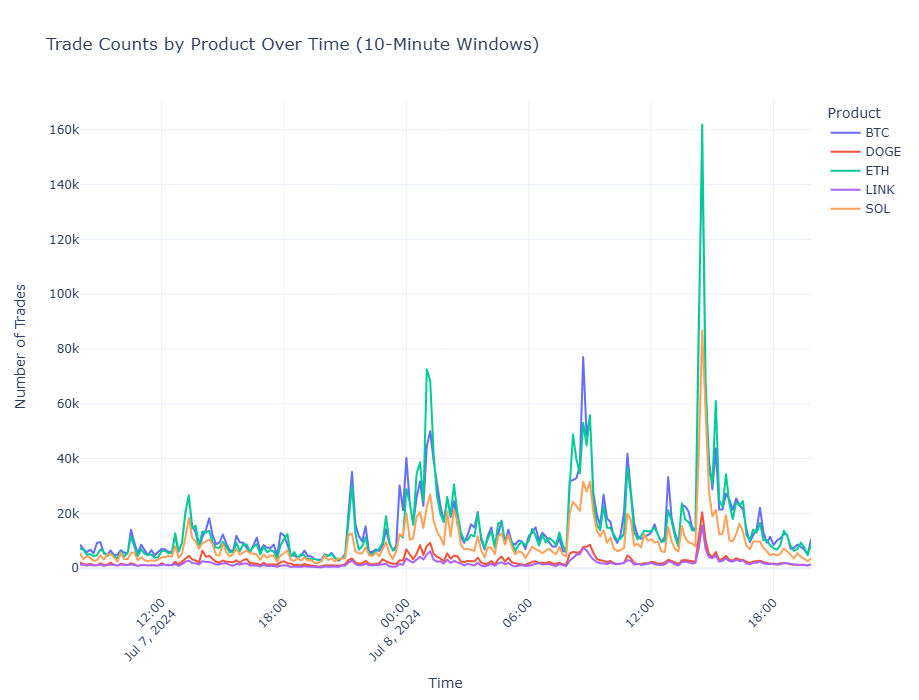

In [150]:
import plotly.express as px

# Convert the timestamp column to datetime if not already
all_trades_wholepd["bucket_10m"] = all_trades_wholepd["bucket_5m"].dt.floor("10T")

# Group by 10-minute buckets and product, counting the number of trades
trade_counts_10m = all_trades_wholepd.groupby(["bucket_10m", "product"]).size().reset_index(name="trade_count")

# Create an interactive Plotly line chart
fig = px.line(
    trade_counts_10m,
    x="bucket_10m",
    y="trade_count",
    color="product",
    title="Trade Counts by Product Over Time (10-Minute Windows)",
    labels={"bucket_10m": "Time (10-min buckets)", "trade_count": "Number of Trades"},
    template="plotly_white"
)

# Improve readability
fig.update_layout(
    autosize=True,
    height=700,
    width=900,
    xaxis_title="Time",
    yaxis_title="Number of Trades",
    legend_title="Product",
    xaxis=dict(showgrid=True, tickangle=-45),
    yaxis=dict(showgrid=True)
)

# Show the interactive plot
fig.show()
